In [1]:
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Feature Engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder


# For clustering
from sklearn.cluster import KMeans

## Importing Data

In [2]:
retail_raw = pd.read_excel('Online Retail.xlsx')

In [3]:
retail_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Preprocessing

In [4]:
clean_retail_data = retail_raw.loc[~((retail_raw.Description.isnull()) | \
                                     retail_raw['Description'].str.contains('wrong', case=False, na=False))].copy()

# Total price per item bought = quantity bought * unit price
clean_retail_data['TotalPrice'] = clean_retail_data['Quantity'] * clean_retail_data['UnitPrice']

In [5]:
# Temporary - Remove records with NaN customer ID
# clean_retail_data = clean_retail_data.loc[clean_retail_data.Cus]

clean_retail_data = clean_retail_data.loc[((clean_retail_data.Quantity > 0) & (clean_retail_data.UnitPrice > 0))]

# Removing outliers from Total Price column
clean_retail_data = \
clean_retail_data.loc[(clean_retail_data['TotalPrice'] >= np.percentile(clean_retail_data['TotalPrice'], 2.5)) \
                    & (clean_retail_data['TotalPrice'] <= np.percentile(clean_retail_data['TotalPrice'], 97.5))
                    & (clean_retail_data['Quantity'] >= np.percentile(clean_retail_data['Quantity'], 2.5))
                    & (clean_retail_data['Quantity'] <= np.percentile(clean_retail_data['Quantity'], 97.5))]\
.reset_index()

In [6]:
# Keeping only the required dataset
X = clean_retail_data.drop(['InvoiceNo','StockCode','InvoiceDate','CustomerID'],axis=1)

X.head(2)

,index,Description,Quantity,UnitPrice,Country,TotalPrice
0,0,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30
1,1,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34


In [7]:
encoder = LabelEncoder()
X.Description = encoder.fit_transform(X.Description.astype(str))
X.Description = X.Description.astype(np.int64)

In [8]:
X.head()

,index,Description,Quantity,UnitPrice,Country,TotalPrice
0,0,3821,6,2.55,United Kingdom,15.30
1,1,3829,6,3.39,United Kingdom,20.34
2,2,882,8,2.75,United Kingdom,22.00
3,3,1851,6,3.39,United Kingdom,20.34
4,4,2832,6,3.39,United Kingdom,20.34


In [9]:
# Create a copy of the DataFrame for scaling
scaled_X = X[['Country', 'Description', 'Quantity', 'UnitPrice', 'TotalPrice']].copy()

# Select the columns for scaling
columns_to_scale = ['Quantity', 'UnitPrice', 'TotalPrice']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
scaled_X[columns_to_scale] = scaler.fit_transform(scaled_X[columns_to_scale])

scaled_X.head()

,Country,Description,Quantity,UnitPrice,TotalPrice
0,United Kingdom,3821,-0.085208,-0.210825,0.161922
1,United Kingdom,3829,-0.085208,0.011637,0.527848
2,United Kingdom,882,0.159644,-0.157858,0.648371
3,United Kingdom,1851,-0.085208,0.011637,0.527848
4,United Kingdom,2832,-0.085208,0.011637,0.527848


In [10]:
scaled_X = pd.get_dummies(scaled_X)
scaled_X.head(2)

,Description,Quantity,UnitPrice,TotalPrice,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,3821,-0.085208,-0.210825,0.161922,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3829,-0.085208,0.011637,0.527848,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

### Elbow plot method for appropriate cluster count

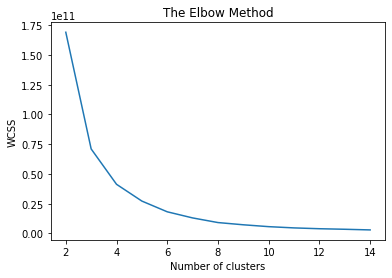

In [11]:
wcss = [] # WCSS = Within Cluster Sum of Squares
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, init = 'k-means++',  random_state = 2)
    kmeans.fit(scaled_X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From the above chart, we can see that the elbow kink is at clusters = 4

### Training the model

In [83]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 2)
y_kmeans = kmeans.fit_predict(scaled_X)

clean_retail_data['Cluster'] = y_kmeans

In [84]:
print(y_kmeans)

[0 0 2 ... 2 2 2]


In [85]:
len(y_kmeans)

502432

In [86]:
clean_retail_data.shape

(502432, 11)

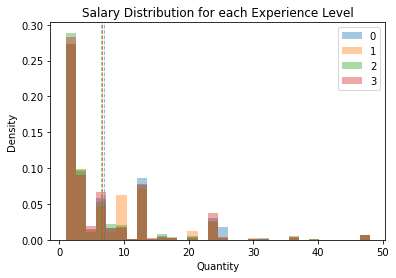

In [87]:
# Group the data by experience level
grouped_data = clean_retail_data.groupby('Cluster')

# Calculate statistics
cluster_stats = grouped_data['Quantity'].agg(['mean', 'std'])

# Plot the distributions
for cluster, stats in cluster_stats.iterrows():
    mean = stats['mean']
    std = stats['std']
    salary_values = clean_retail_data[clean_retail_data['Cluster'] == cluster]['Quantity']
    
    # Assigning a colour to each category; same colour for distribution and mean
    color = plt.cm.tab10(cluster_stats.index.get_loc(cluster))  # Assign a color to each category
    plt.hist(salary_values, bins=30, density=True, alpha=0.4, label=cluster, color=color)
    plt.axvline(mean, color=color, linestyle='dashed', linewidth=1, alpha=0.5)  # Use the same color for the mean line
    
# Formatting the y-axis tick labels
plt.ticklabel_format(style='plain', axis='y')  # Display decimal numbers
    
plt.legend()
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.title('Salary Distribution for each Experience Level')
plt.show()


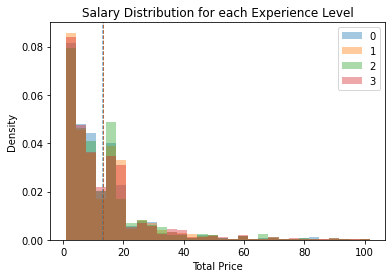

In [88]:
# Group the data by experience level
grouped_data = clean_retail_data.groupby('Cluster')

# Calculate statistics
cluster_stats = grouped_data['TotalPrice'].agg(['mean', 'std'])

# Plot the distributions
for cluster, stats in cluster_stats.iterrows():
    mean = stats['mean']
    std = stats['std']
    salary_values = clean_retail_data[clean_retail_data['Cluster'] == cluster]['TotalPrice']
    
    # Assigning a colour to each category; same colour for distribution and mean
    color = plt.cm.tab10(cluster_stats.index.get_loc(cluster))  # Assign a color to each category
    plt.hist(salary_values, bins=30, density=True, alpha=0.4, label=cluster, color=color)
    plt.axvline(mean, color=color, linestyle='dashed', linewidth=1, alpha=0.5)  # Use the same color for the mean line
    
# Formatting the y-axis tick labels
plt.ticklabel_format(style='plain', axis='y')  # Display decimal numbers
    
plt.legend()
plt.xlabel('Total Price')
plt.ylabel('Density')
plt.title('Salary Distribution for each Experience Level')
plt.show()


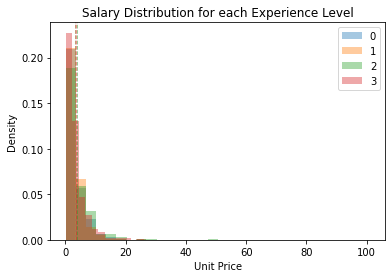

In [89]:
# Group the data by experience level
grouped_data = clean_retail_data.groupby('Cluster')

# Calculate statistics
cluster_stats = grouped_data['UnitPrice'].agg(['mean', 'std'])

# Plot the distributions
for cluster, stats in cluster_stats.iterrows():
    mean = stats['mean']
    std = stats['std']
    salary_values = clean_retail_data[clean_retail_data['Cluster'] == cluster]['UnitPrice']
    
    # Assigning a colour to each category; same colour for distribution and mean
    color = plt.cm.tab10(cluster_stats.index.get_loc(cluster))  # Assign a color to each category
    plt.hist(salary_values, bins=30, density=True, alpha=0.4, label=cluster, color=color)
    plt.axvline(mean, color=color, linestyle='dashed', linewidth=1, alpha=0.5)  # Use the same color for the mean line
    
# Formatting the y-axis tick labels
plt.ticklabel_format(style='plain', axis='y')  # Display decimal numbers
    
plt.legend()
plt.xlabel('Unit Price')
plt.ylabel('Density')
plt.title('Salary Distribution for each Experience Level')
plt.show()


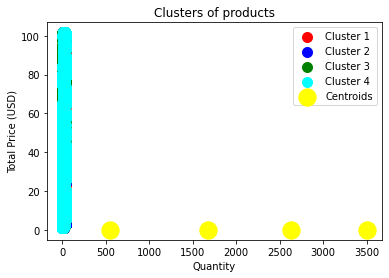

In [90]:
plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==0, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==0, ['TotalPrice']]
            , s = 100, c='red', label = 'Cluster 1')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==1, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==1, ['TotalPrice']]
            , s = 100, c='blue', label = 'Cluster 2')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==2, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==2, ['TotalPrice']]
            , s = 100, c='green', label = 'Cluster 3')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==3, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==3, ['TotalPrice']]
            , s = 100, c='cyan', label = 'Cluster 4')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='yellow', label="Centroids")

plt.title('Clusters of products')
plt.xlabel('Quantity')
plt.ylabel('Total Price (USD)')
plt.legend()
plt.show()

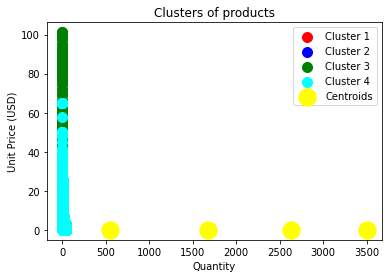

In [91]:
plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==0, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==0, ['UnitPrice']]
            , s = 100, c='red', label = 'Cluster 1')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==1, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==1, ['UnitPrice']]
            , s = 100, c='blue', label = 'Cluster 2')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==2, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==2, ['UnitPrice']]
            , s = 100, c='green', label = 'Cluster 3')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==3, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==3, ['UnitPrice']]
            , s = 100, c='cyan', label = 'Cluster 4')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='yellow', label="Centroids")

plt.title('Clusters of products')
plt.xlabel('Quantity')
plt.ylabel('Unit Price (USD)')
plt.legend()
plt.show()

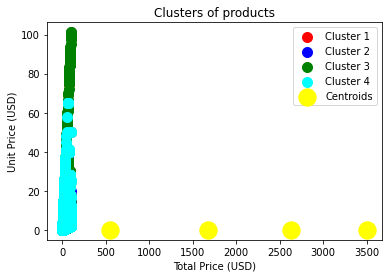

In [92]:
plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==0, ['TotalPrice']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==0, ['UnitPrice']]
            , s = 100, c='red', label = 'Cluster 1')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==1, ['TotalPrice']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==1, ['UnitPrice']]
            , s = 100, c='blue', label = 'Cluster 2')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==2, ['TotalPrice']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==2, ['UnitPrice']]
            , s = 100, c='green', label = 'Cluster 3')

plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==3, ['TotalPrice']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==3, ['UnitPrice']]
            , s = 100, c='cyan', label = 'Cluster 4')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='yellow', label="Centroids")

plt.title('Clusters of products')
plt.xlabel('Total Price (USD)')
plt.ylabel('Unit Price (USD)')
plt.legend()
plt.show()

Now I am trying to understand the pattern in each cluster

#### Cluster 1

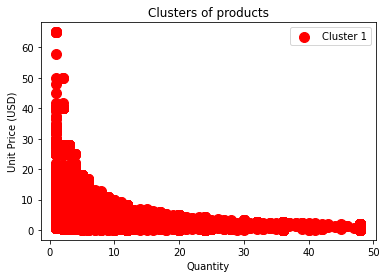

In [50]:
plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==0, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==0, ['UnitPrice']]
            , s = 100, c='red', label = 'Cluster 1')


plt.title('Clusters of products')
plt.xlabel('Quantity')
plt.ylabel('Unit Price (USD)')
plt.legend()
plt.show()

#### Cluster 2

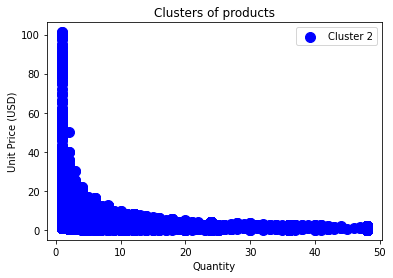

In [52]:
plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==1, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==1, ['UnitPrice']]
            , s = 100, c='blue', label = 'Cluster 2')


plt.title('Clusters of products')
plt.xlabel('Quantity')
plt.ylabel('Unit Price (USD)')
plt.legend()
plt.show()

#### Cluster 3

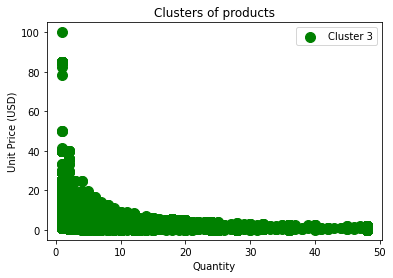

In [53]:
plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==2, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==2, ['UnitPrice']]
            , s = 100, c='green', label = 'Cluster 3')

plt.title('Clusters of products')
plt.xlabel('Quantity')
plt.ylabel('Unit Price (USD)')
plt.legend()
plt.show()

#### Cluster 4

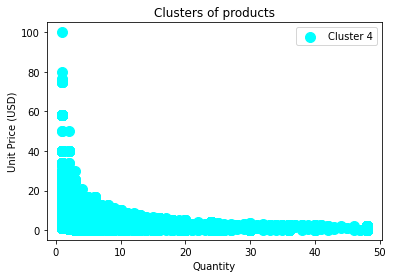

In [54]:
plt.scatter(clean_retail_data.loc[clean_retail_data.Cluster==3, ['Quantity']]\
            , clean_retail_data.loc[clean_retail_data.Cluster==3, ['UnitPrice']]
            , s = 100, c='cyan', label = 'Cluster 4')

plt.title('Clusters of products')
plt.xlabel('Quantity')
plt.ylabel('Unit Price (USD)')
plt.legend()
plt.show()